# Problem Statement 
The problem is to predict annual water usage. The dataset provides the annual water usage
in Baltimore from 1885 to 1963, or 79 years of data. The values are in the units of liters per
capita per day, and there are 79 observations. The dataset is credited to Hipel and McLeod,
1994.

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot
from pandas import DataFrame
from pandas import Grouper
from statsmodels.tsa.stattools import adfuller
from pandas import Series

## Test Harness
We will develop a test harness to investigate the data and evaluate candidate models. This involves two steps:-
1. Creating a Validation dataset.
2. Developing a Method for Model Evaluation.

#### 1. Creating a Validation dataset
Since we don't have any data after 1963, so will assume that we have data only from 1885 to 1953 (69 years) and the last 10 years data will be considered as new data (validation data) for evaluating our model.
Therefore, last 10 years data will not be used for model analysis or evaluation. It will be used to evaluate the performance of our trained models.

In [2]:
# separate out a validation dataset
series = read_csv('water.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
split_point = len(series) - 10
dataset, validation = series[0:split_point], series[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv', header=False)          # name of training dataset
validation.to_csv('validation.csv', header=False)    # name of validation dataset

Dataset 69, Validation 10


Observe that Validation dataset is roughly 12% of the total data.

#### 2. Model Evaluation
We will consider Root Mean Squared Error (RMSE) as performance metric. And walk-forward validation will be used for model evaluation.  

Check Appendix in the end to know about walk-forward validation.

## Data Analysis

We will use summary statistics and plots of data to understand the structure of prediction problem and analyse the data. We will look data from the following four perspective:-
1. Summary Statistics.
2. Line Plot.
3. Density Plots.
4. Box and Whisker Plot.

#### 1. Summary Statistics

In [3]:
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
print(series.describe())

count     69.000000
mean     500.478261
std       73.901685
min      344.000000
25%      458.000000
50%      492.000000
75%      538.000000
max      662.000000
Name: 1, dtype: float64


Observations:-
* Count of series is same as what we are expecting, which means we are handling the data correctly.
* Mean of series is 500 and standard deviation is 73.9
* Standard deviation and percentile suggests that data is tightly spread around the mean.

#### 2. Line Plot
A line plot of timeseries data can provide lot of insights to understand the problem.

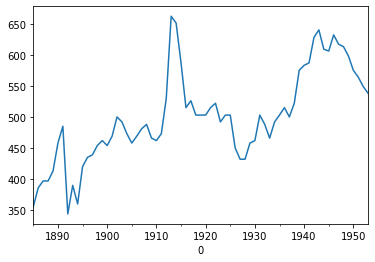

In [4]:
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
series.plot()
pyplot.show()

Observations:-
* Annual water usage is overall increasing with time.
* We can observe a sudden spike in consumption between 1910 to 1920 (around 1915)
* There do not appear to be any outliers in the data, although there are sudden spikes and dip. 
* In last few years, water usage is decreasing.

#### 3. Density Plots
Studying plots of the density of observations can further provide insights into patterns in data. 

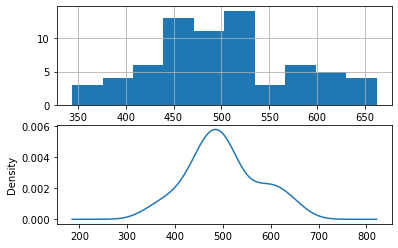

In [5]:
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
pyplot.figure(1)
pyplot.subplot(211)
series.hist()
pyplot.subplot(212)
series.plot(kind='kde')
pyplot.show()

Observations :-
* Distribution is very close to a gaussian distribution, although it's not a gaussian.
* Observe that distribution has a long right tail, this may imply that distribution is exponential or double gaussian.

#### 4. Box and Whisker Plots
We will group the data in decades and find out if there are any trend for water usage per decade.

<>:5: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:5: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-6-27eba0b60451>:5: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if len(group.values) is 10:


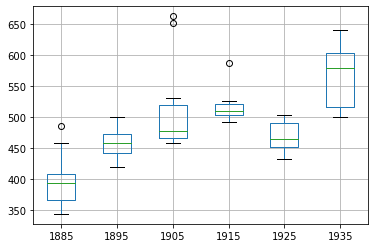

In [6]:
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
groups = series.groupby(Grouper(freq='10YS'))
decades = DataFrame()
for name, group in groups:
    if len(group.values) is 10:
        decades[name.year] = group.values
decades.boxplot()
pyplot.show()

Observations:-
* There might be outliers present in some decades (going out of the box).
* Observe that second last decade has less water consumption, this might be due to First World War.

## Baseline Model

We will build a Persistance model as a baseline model. 
Our Timeseries forecasting model must predict better than this baseline model.

In [7]:
# load data
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)           # first 50% will be train.
train, test = X[0:train_size], X[train_size:]                   # remaining 50% will be used for testing.
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # predict
    yhat = history[-1]
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=503.000, Expected=503.000
>Predicted=503.000, Expected=503.000
>Predicted=503.000, Expected=515.000
>Predicted=515.000, Expected=522.000
>Predicted=522.000, Expected=492.000
>Predicted=492.000, Expected=503.000
>Predicted=503.000, Expected=503.000
>Predicted=503.000, Expected=450.000
>Predicted=450.000, Expected=432.000
>Predicted=432.000, Expected=432.000
>Predicted=432.000, Expected=458.000
>Predicted=458.000, Expected=462.000
>Predicted=462.000, Expected=503.000
>Predicted=503.000, Expected=488.000
>Predicted=488.000, Expected=466.000
>Predicted=466.000, Expected=492.000
>Predicted=492.000, Expected=503.000
>Predicted=503.000, Expected=515.000
>Predicted=515.000, Expected=500.000
>Predicted=500.000, Expected=522.000
>Predicted=522.000, Expected=575.000
>Predicted=575.000, Expected=583.000
>Predicted=583.000, Expected=587.000
>Predicted=587.000, Expected=628.000
>Predicted=628.000, Expected=640.000
>Predicted=640.000, Expected=609.000
>Predicted=609.000, Expected=606.000
>

Observe that Root Mean Squared Error (RMSE) of Persitance model (which is baseline model) is 21.975. This means that on average, model was wrong by approximately 22 litres per capita per day for each prediction made.

## ARIMA Models
Now we make AutoRegressive Integrated Moving Average (or ARIMA) Models for this problem.
We will perform the following tasks:-
1. Manually Configure the ARIMA.
2. Automatically Configure the ARIMA.
3. Analyse residual errors.

Analysis of the Timeseries data assumes that the time-series is stationary. This is likely a non-stationary time series. We make it stationary by differencing the series and use statistical test to validate if the series is stationary.

ADF Statistic: -6.126719
p-value: 0.000000
Critical Values:
	1%: -3.534
	5%: -2.906
	10%: -2.591


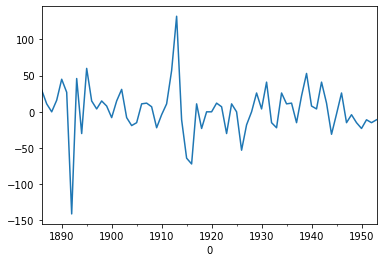

In [8]:
# create and summarize a stationary version of the time series
# create a differenced series
def difference(dataset):
    diff = list()
    for i in range(1, len(dataset)):
        value = dataset[i] - dataset[i - 1]
        diff.append(value)
    return Series(diff)
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
X = series.values
X = X.astype('float32')
# difference data
stationary = difference(X)
stationary.index = series.index[1:]
# check if stationary
result = adfuller(stationary)        # This is augmented dickey-fuller test.
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
# plot differenced data
stationary.plot()
pyplot.show()
# save
stationary.to_csv('stationary.csv', header=False)

    

* The results show that the test statistic value -6.126719 is smaller than the critical value at 1% of -3.534. Thus, we can reject null hypothesis, which implies that series is indeed stationary.
* This suggests that atleast one level of differencing is required. Therefore the d parameter for our ARIMA model should atleat be 1. 
* Looking at the above plot of differenced data, we can observe that the increasing trend is indeed vanished.

Now we find the Autoregression (AR) and Moving Average (MA) parameters, p and q, respectively for our ARIMA Model. This can be achieved using the Autocorrelation Function(ACF) and Partial Autocorrelation Function (PACF) plots.

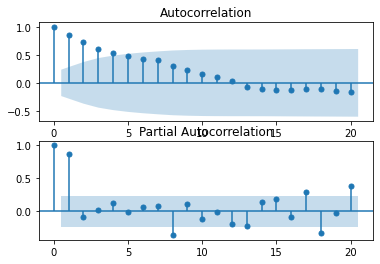

In [9]:
# ACF and PACF plots of the time series
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
pyplot.figure()
pyplot.subplot(211)
plot_acf(series, lags=20, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(series, lags=20, ax=pyplot.gca())
pyplot.show()

Observations:-
* ACF shows significant lag till 4th time step.
* PACF shows significant lag till 1st time step.


Therefore for starting, we can consider p as 4, and q as 1. We now start with ARIMA (4,1,1) for our model.

#### First ARIMA Model

In [10]:
# evaluate a manually configured ARIMA model
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt
import warnings
warnings.filterwarnings("ignore")
# load data
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # predict
    model = ARIMA(history, order=(4,1,1))
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=548.319, Expected=503.000
>Predicted=545.085, Expected=503.000
>Predicted=546.061, Expected=515.000
>Predicted=550.660, Expected=522.000
>Predicted=552.011, Expected=492.000
>Predicted=519.221, Expected=503.000
>Predicted=527.953, Expected=503.000
>Predicted=534.026, Expected=450.000
>Predicted=474.119, Expected=432.000
>Predicted=456.458, Expected=432.000
>Predicted=465.408, Expected=458.000
>Predicted=481.425, Expected=462.000
>Predicted=476.156, Expected=503.000
>Predicted=511.083, Expected=488.000
>Predicted=497.183, Expected=466.000
>Predicted=460.301, Expected=492.000
>Predicted=506.310, Expected=503.000
>Predicted=515.928, Expected=515.000
>Predicted=516.368, Expected=500.000
>Predicted=504.364, Expected=522.000
>Predicted=525.885, Expected=575.000
>Predicted=579.358, Expected=583.000
>Predicted=575.313, Expected=587.000
>Predicted=573.357, Expected=628.000
>Predicted=622.136, Expected=640.000
>Predicted=632.299, Expected=609.000
>Predicted=595.783, Expected=606.000
>

#### Grid Search ARIMA Model
Now we perform Grid search on (p,d,q) parameters of arima model to get the best possible model. We search for the following combinations:-
* p: 0 to 5.
* d: 0 to 3.
* q: 0 to 5.

In [11]:
# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.50)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        # model_fit = model.fit(disp=0)
        model_fit = model.fit(trend='nc', disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                        print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
# load dataset
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# evaluate parameters
p_values = range(0, 6)
d_values = range(0, 4)
q_values = range(0, 6)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 1) RMSE=282.658
ARIMA(0, 0, 2) RMSE=160.229
ARIMA(0, 0, 3) RMSE=97.015
ARIMA(0, 0, 4) RMSE=77.298
ARIMA(0, 0, 5) RMSE=58.748
ARIMA(0, 1, 1) RMSE=21.907
ARIMA(2, 1, 0) RMSE=21.733
Best ARIMA(2, 1, 0) RMSE=21.733


We observe that ARIMA(2, 1 ,0) is the best model with RMSE of 21.733, which is just slightly better than the persistance model RMSE of 21.975.

#### Reviewing Residual Errors
Ideally the distribution of residual errors should be a Gaussian with zero mean. Analysis of residual errors is a good final check for validity of our model.

               0
count  35.000000
mean    1.081623
std    22.022566
min   -52.103811
25%   -16.202285
50%    -0.459805
75%    12.085092
max    51.284333


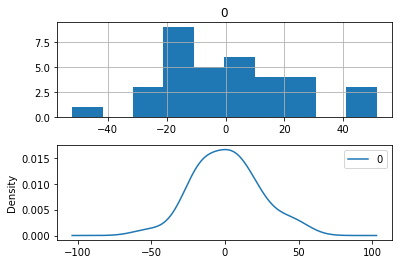

In [12]:
# load data
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # predict
    model = ARIMA(history, order=(2,1,0))
    model_fit = model.fit(trend='nc', disp=0)
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())
pyplot.figure()
pyplot.subplot(211)
residuals.hist(ax=pyplot.gca())
pyplot.subplot(212)
residuals.plot(kind='kde', ax=pyplot.gca())
pyplot.show()

Observe that the mean is non-zero (1.081). This suggests that predictions are biased. Therefore for our bias-correct predictions, we will add a mean residual error of 1.081 in each forecast made.

RMSE: 21.706
               0
count  35.000000
mean   -0.000001
std    22.022566
min   -53.185435
25%   -17.283909
50%    -1.541429
75%    11.003468
max    50.202709


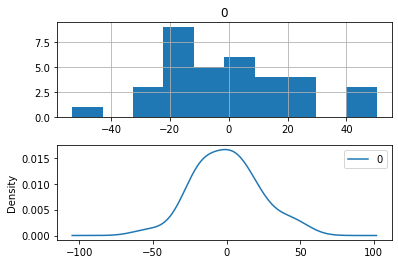

In [13]:
# load data
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
bias = 1.081624
for i in range(len(test)):
    # predict
    model = ARIMA(history, order=(2,1,0))
    model_fit = model.fit(trend='nc', disp=0)
    yhat = bias + float(model_fit.forecast()[0])
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)
# summarize residual errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())
# plot residual errors
pyplot.figure()
pyplot.subplot(211)
residuals.hist(ax=pyplot.gca())
pyplot.subplot(212)
residuals.plot(kind='kde', ax=pyplot.gca())
pyplot.show()

Observe that the residual error mean is now very close to 0. And the density plot of the residual error do show a shift towards zero. 

## Model Validation
Now we have developed and finalized our best model. The last step is to validate the model and make a final check to ensure we have not made a wrong choice of model or misled ourselves.

#### Finalize Model

In [14]:
# save finalized model to file
from statsmodels.tsa.arima_model import ARIMA
import numpy
# monkey patch around bug in ARIMA class
def __getnewargs__(self):
    return ((self.endog),(self.k_lags, self.k_diff, self.k_ma))

ARIMA.__getnewargs__ = __getnewargs__
# load data
series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = series.values
X = X.astype('float32')
# fit model
model = ARIMA(X, order=(2,1,0))
model_fit = model.fit(trend='nc', disp=0)
# bias constant, we calculated previously.
bias = 1.081624
# save model
model_fit.save('model.pkl')
numpy.save('model_bias.npy', [bias])

#### Make Prediction
We now load our saved model and saved bias to make a single prediction from our model. We use forecast() function to make prediction.

In [15]:
# load finalized model and make a prediction
from statsmodels.tsa.arima_model import ARIMAResults
import numpy
model_fit = ARIMAResults.load('model.pkl')
bias = numpy.load('model_bias.npy')
yhat = bias + float(model_fit.forecast()[0])
print('Predicted: %.3f' % yhat)

Predicted: 540.013


#### Persistance model (baseline) for the validation dataset.

In [16]:
# load data
series = read_csv('validation.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)           # first 50% will be train.
train, test = X[0:train_size], X[train_size:]                   # remaining 50% will be used for testing.
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # predict
    yhat = history[-1]
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=602.000, Expected=594.000
>Predicted=594.000, Expected=587.000
>Predicted=587.000, Expected=587.000
>Predicted=587.000, Expected=625.000
>Predicted=625.000, Expected=613.000
RMSE: 18.445


RMSE of baseline persistance model for the validation data is 18.445

#### Validate Model
* At start, we seperated the last 10 years data as validation.csv file. We will use this file to make prediction on last 10 years data. 
* One way of making prediction is to directly predict for 10 years data, in this method after 1-2 years model accuracy will decrease. 
* We will however use rolling-forecast method to make prediction, where we update and transform the model after each time step. This is the preferred method used in practice as it gives the best performance.


>Predicted=540.013, Expected=568.000
>Predicted=571.589, Expected=575.000
>Predicted=573.289, Expected=579.000
>Predicted=579.561, Expected=587.000
>Predicted=588.063, Expected=602.000
>Predicted=603.022, Expected=594.000
>Predicted=593.178, Expected=587.000
>Predicted=588.558, Expected=587.000
>Predicted=588.797, Expected=625.000
>Predicted=627.941, Expected=613.000
RMSE: 16.532


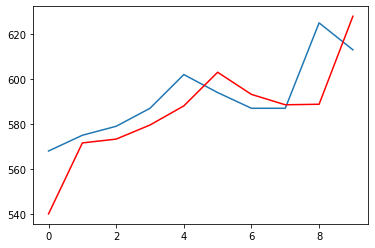

In [17]:
# load and evaluate the finalized model on the validation dataset
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy
# load and prepare datasets
dataset = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
X = dataset.values.astype('float32')
history = [x for x in X]

validation = read_csv('validation.csv', header=None, index_col=0, parse_dates=True,
squeeze=True)
y = validation.values.astype('float32')
# load model
model_fit = ARIMAResults.load('model.pkl')
bias = numpy.load('model_bias.npy')
# make first prediction
predictions = list()
yhat = bias + float(model_fit.forecast()[0])
predictions.append(yhat)
history.append(y[0])
print('>Predicted=%.3f, Expected=%.3f' % (yhat, y[0]))
# rolling forecasts
for i in range(1, len(y)):
    # predict
    model = ARIMA(history, order=(2,1,0))
    model_fit = model.fit(trend='nc', disp=0)
    yhat = bias + float(model_fit.forecast()[0])
    predictions.append(yhat)
    # observation
    obs = y[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(y, predictions))
print('RMSE: %.3f' % rmse)
pyplot.plot(y)
pyplot.plot(predictions, color='red')
pyplot.show()

Above is the line plot of the expected values (blue) and the prediction values (red) for the validation set.

## SUMMARY
* Observe that RMSE of our model is 16.532 whereas RMSE of baseline persistance model is 18.445 for validation dataset.
* This implies that our model performance in validation dataset is better than the baseline model.
* Also, observe that this timeseries doesn't have any particular trend. Hence we are not able to develop a high performing model.

## Appendix

 * ### Walk-forward validation

This Project is inspired from the book __Introduction to Time Series forecasting with Python__ by __Jason Brownlee__. 

Future Work
* Prepare Time Series data for CNN and LSTMs neural network architecture.
* Train CNN and LSTMs on TS data.
* Predict using CNNs and LSTMs.